# Using MCMC For Bayesian Survival Analysis

A quick tutorial using data we are all familiar with on how to set up and run a very simple test of hazard differences in a bayesian framework. 

In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk
import seaborn as sns
from statsmodels import datasets
from theano import tensor as T
import pandas as pd

## Import our data. 

We will use the `alloauto` dataset from the `KMsurv` package in R. 

In [3]:
allo = pd.read_csv("alloauto.csv")
allo.head()

,time,type,delta
0,0.030,1,1
1,0.493,1,1
2,0.855,1,1
3,1.184,1,1
4,1.283,1,1


So we can see we have the time to observation as `time`, death or not as `delta` and in this case we will look to see if there is a difference in hazard rates between two different transplant methods: `allo` (`1`) or `auto` (`2`), stored in the column `type`. 

In [4]:
allo.delta.mean()

0.49504950495049505

In [5]:
n_patients = allo.shape[0]
n_patients

101

We can see that we have a very large number of censored values in this dataset, with just about a 50-50 split between observed and censored events. 

In [6]:
#make sure deltas are in proper encoding. 
allo.delta = allo.delta.astype(np.int64)

#recode type to be 0s and 1s for ease of computation
allo.race =(allo.type - 1).astype(np.int64) 

#setup some stuff for later with pymc
patients = np.arange(n_patients)

## Looking at our data

Let's quickly plot the data to make sure we're all set and nothing weird is going on. 

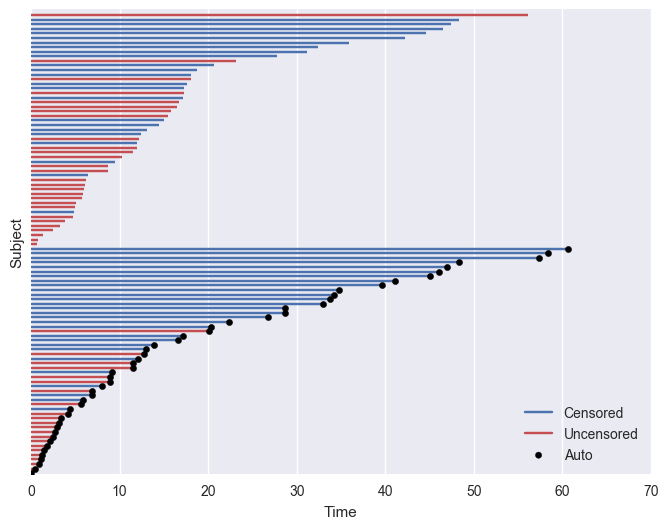

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red = sns.color_palette()[:3]

ax.hlines(patients[allo.delta.values == 0], 0, \
          allo[allo.delta.values == 0].time,
          color=blue, label='Censored')

ax.hlines(patients[allo.delta.values == 1], 0, \
          allo[allo.delta.values == 1].time,
          color=red, label='Uncensored')

ax.scatter(allo[allo.type.values == 1].time, \
           patients[allo.type.values == 1],
           color='k', zorder=10, label='Auto')

ax.set_xlim(left=0)
ax.set_xlabel('Time')
ax.set_yticks([])
ax.set_ylabel('Subject')

ax.set_ylim(-0.25, n_patients + 0.25)

ax.legend(loc='lower right');

We need to come up with a prior not only for the $\beta$s but also for the baseline hazard function $h_0(t)$ in our cox model form 
$$h(t) = h_0(t)\exp{[\beta_0+ x\beta]}$$

A common technique with bayesian survival is to treat the baseline hazard as a piecewise constant function. To do this we need to divide our timeline up into increments. We will arbitrarily choose 1.5 months in this case. 

In [8]:
interval_length = 1.5
interval_bounds = np.arange(0, allo.time.max() + \
                            interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

We can plot a quick histogram to see what this actually looks like to make sure we havent made any big mistakes

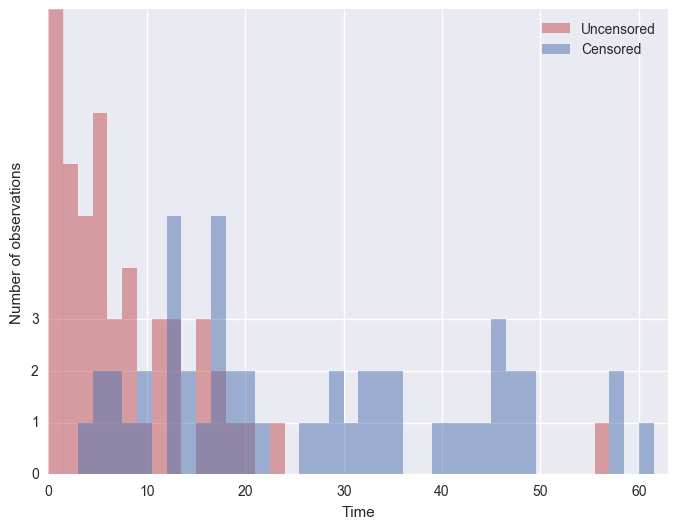

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(allo[allo.delta == 1].time.values, bins=interval_bounds,
        color=red, alpha=0.5, lw=0,
        label='Uncensored');
ax.hist(allo[allo.delta == 0].time.values, bins=interval_bounds,
        color=blue, alpha=0.5, lw=0,
        label='Censored');

ax.set_xlim(0, interval_bounds[-1]);
ax.set_xlabel('Time');

ax.set_yticks([0, 1, 2, 3]);
ax.set_ylabel('Number of observations');

ax.legend();

Looks pretty good to me. 

Now let's run through our data for each individual to create indicators of if the $i^{th}$ patient died in the $j^{th}$ interval (of the ones we just defined). 

In [10]:
last_period = np.floor((allo.time - 0.01) / interval_length).astype(int)

death = np.zeros((n_patients, n_intervals))
death[patients, last_period] = allo.delta

Now we encode the risk level for the $i^{th}$ patient in the $j^{th}$ interval. 

In [11]:
exposure = np.greater_equal.outer(allo.time, \
                                  interval_bounds[:-1]) * interval_length
exposure[patients, last_period] = allo.time - interval_bounds[last_period]

## The Actual Model

Now we can get to the good part. 

First we will show the model and then explain it line by line. 

In [12]:
with pm.Model() as model:

    h0 = pm.Gamma('h0', 0.01, 0.01, shape=n_intervals)

    beta = pm.Normal('beta', 0, sd=1000)

    h_ = pm.Deterministic('h_', T.outer(T.exp(beta * allo.type), h0))
    mu = pm.Deterministic('mu', exposure * h_)

    obs = pm.Poisson('obs', mu, observed=death)


Applied log-transform to h0 and added transformed h0_log_ to model.


We start by setting our prior on the baseline hazard rate $h_0$. 

`h0 = pm.Gamma('h0', 0.01, 0.01, shape=n_intervals)`

By choosing the peicewise model from before for the intervals of time, we are essentially treating this as poisson (time intervals and number of events in those intervals) so we will use a gamma prior on the poisson rate parameter. 

Next, we will set the prior for $\beta$ as normal.

`beta = pm.Normal('beta', 0, sd=1000)`

We have chosen a centered normal (`mu = 0`) that is rather wide (`sd=1000`). Since we only have a single covariate in this model (`race`) we only need a univariate normal. 

The last couple of lines are just setup stuff for `pymc` and can be ignored for now. 

In [13]:
n_samples = 1000
with model:
    trace_ = pm.sample(n_samples)

Assigned NUTS to h0_log_
Assigned NUTS to beta
100%|██████████| 1000/1000 [49:52<00:00,  2.56s/it]


Phew, it's done. Turns out MCMC is really slow in cases where we have a large number of observations. Just this super simple model with 1000 samples took 50 mins to run. 

Next we can extract the posterior from the model and check our mean.

In [59]:
trace = trace_[100:]
np.exp(trace['beta'].mean())

1.1442151491666235

The mean of our beta-estimate posterior of 1.14 doesnt exactly scream a lot of difference in the hazard rates, but just to make sure let's plot the posterior distribution to see what we have. 

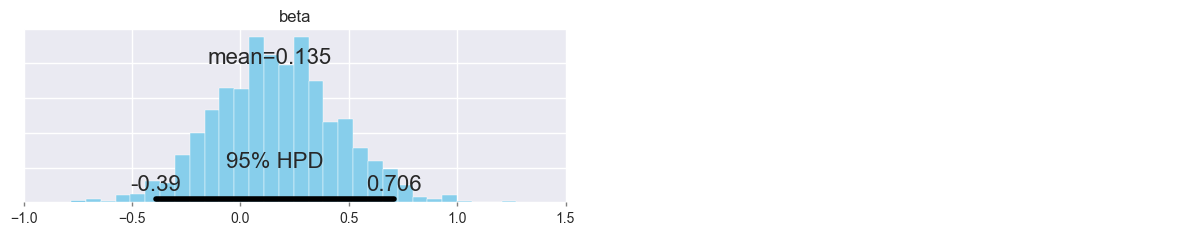

In [56]:
post_plot = pm.plot_posterior(trace, varnames=['beta'], color='#87ceeb')

Again, suspicions confirmed. No statistician would call that different. Even one with heavy priors. 

This result is nice to inteprate, as it is the distribution of our estimate for $\beta_1$ or the coefficient associated with differences in race. Thus we can say, given our prior and data there is a 95 percent chance the true difference is rates is between -0.39 and 0.71, a luxury we didn't have with frequentist methods. 

Again though, let's just visualize the results  a bit more to give an idea of the type of intepretations we can get with the bayesian approach. 

In [60]:
base_hazard = trace['h0']
met_hazard = trace['h0'] * np.exp(np.atleast_2d(trace['beta']).T)

def cum_hazard(hazard):
    return (interval_length * hazard).cumsum(axis=-1)

def survival(hazard):
    return np.exp(-cum_hazard(hazard))


def plot_with_hpd(x, hazard, f, ax, color=None, label=None, alpha=0.05):
    mean = f(hazard.mean(axis=0))

    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(hazard), percentiles, axis=0)

    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, mean, color=color, label=label);

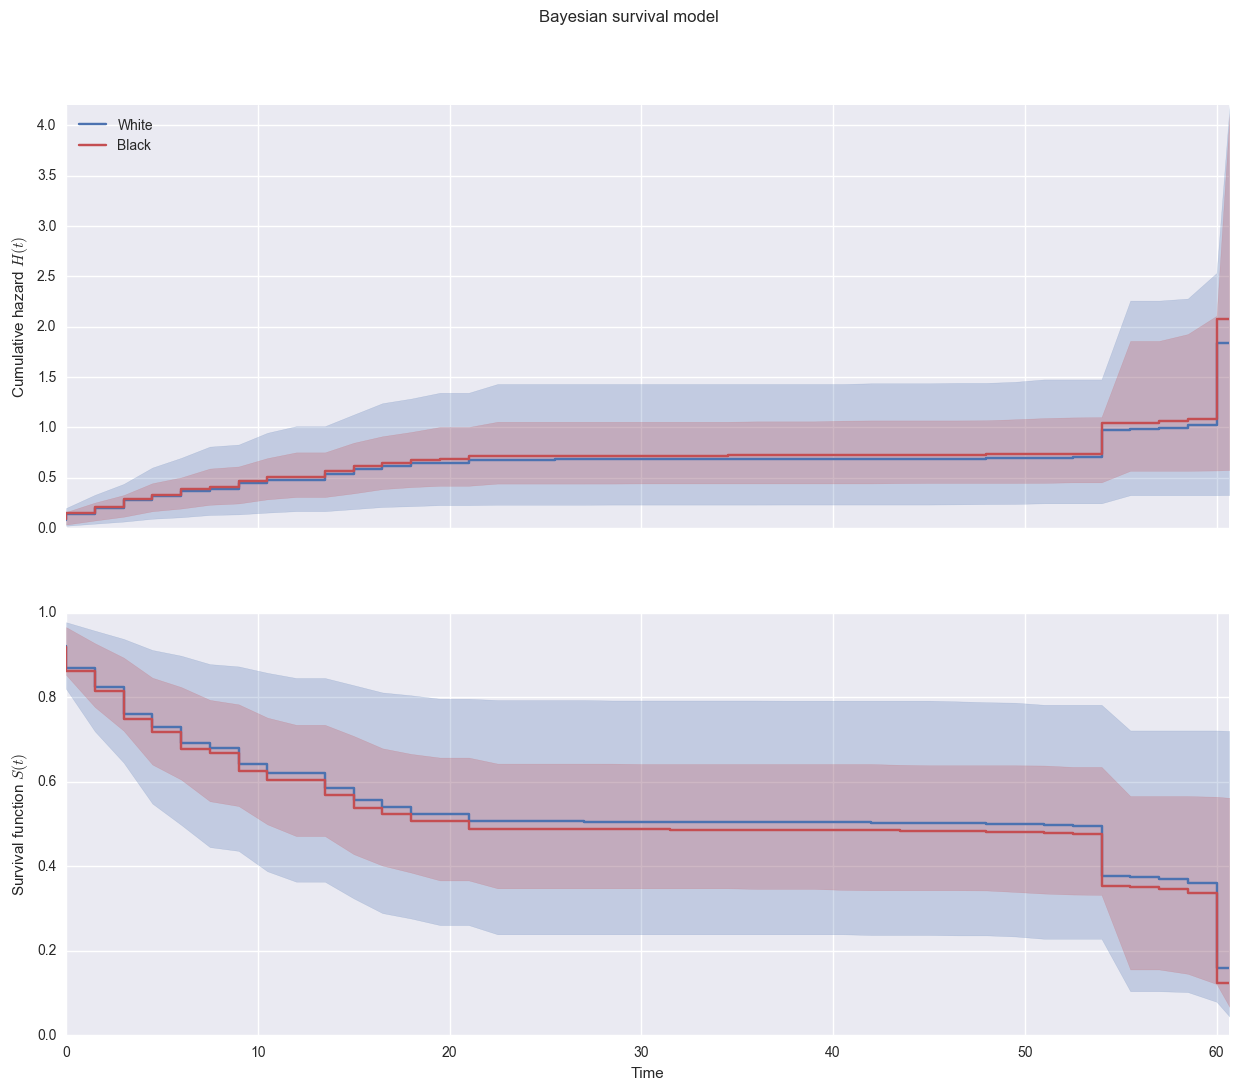

In [61]:
fig, (hazard_ax, surv_ax) = plt.subplots(nrows=2, sharex=True, \
                                         sharey=False, figsize=(15, 12))

plot_with_hpd(interval_bounds[:-1], base_hazard, cum_hazard,
              hazard_ax, color=blue, label='White')

plot_with_hpd(interval_bounds[:-1], met_hazard, cum_hazard,
              hazard_ax, color=red, label='Black')

hazard_ax.set_xlim(0, allo.time.max());
hazard_ax.set_xlabel('');

hazard_ax.set_ylim(0, 4.2);
hazard_ax.set_ylabel(r'Cumulative hazard $H(t)$');

hazard_ax.legend(loc=2);

plot_with_hpd(interval_bounds[:-1], base_hazard, survival,
              surv_ax, color=blue)

plot_with_hpd(interval_bounds[:-1], met_hazard, survival,
              surv_ax, color=red)

surv_ax.set_xlim(0, allo.time.max());
surv_ax.set_xlabel('Time');

surv_ax.set_ylabel('Survival function $S(t)$');

fig.suptitle('Bayesian survival model');

What we are looking at here is our estimates along with credible intervals, or intervals that we are 95% sure that our true value is contained within. Nicer to deal with than confidence intervals in my opinion. 

---
A large large amount of the inspiration and code for this came from the [pymc-devs github](https://pymc-devs.github.io/pymc3/). It's a highly recomended resource for learning about this MCMC Bayesian computing. 